In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import itertools

In [42]:
### SHOULD YOU TRY SCALING?

In [43]:
## Make folder to save best params
best_param_folder = '/home/erussek/projects/RNNs/best_hyper_params_fix_only'
if not os.path.exists(best_param_folder):
    os.mkdir(best_param_folder)
best_param_dict = {}

In [44]:
def load_results(run_idx, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout):
    
    to_save_folder = '/scratch/gpfs/erussek/RNN_project/Hyper_Param_Search2'
    
    if dropout>0:
        res_name_full = 'run_{}_model_name_{}_d_model_{}_sim_lr_{}_human_lr_{}_n_head_{}_n_layers_{}_nsim_{}_nhum_{}_do_{}_fu_ID_fix_only'.format(run_idx, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout)
    else:
        res_name_full = 'run_{}_model_name_{}_d_model_{}_sim_lr_{}_human_lr_{}_n_head_{}_n_layers_{}_nsim_{}_nhum_{}_fu_ID_fix_only'.format(run_idx, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train)

    param_dict = {'model_name':model_name, 'd_model':d_model, 'sim_lr':sim_lr, 'human_lr':human_lr, 'n_head':n_head, 'n_layers':n_layers, 'n_simulation_sequences_train':n_simulation_sequences_train, 'n_human_sequences_train':n_human_sequences_train, 'dropout': dropout}                  
    res_file_name = res_name_full + '.pickle'
    res_full_file_name = os.path.join(to_save_folder, res_file_name)
    file = open(res_full_file_name, 'rb')
    res = pickle.load(file)
    return res, param_dict

def load_results_all_runs(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 3):
    
    results_list = []
    
    for run_idx in range(n_runs):
        res, param_dict = load_results(run_idx, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout)
        results_list.append(res)
        
    return results_list, param_dict

def get_learning_curve_train_sim_or_human(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 3, which_loss = 'simulation_loss_results'): 
    
    results_list, param_dict = load_results_all_runs(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = n_runs)
    
    loss_results_by_run = np.array([res[which_loss] for res in results_list])
    
    return np.mean(loss_results_by_run, axis=0), np.std(loss_results_by_run, axis=0)/np.sqrt(n_runs), results_list[0]['train_sequence_number'], results_list[0]['simulation_sequence_number'], results_list[0]['human_sequence_number'], param_dict

In [45]:
# types of models...
model_names = ['LSTM', 'GRU', 'Transformer']

### Train on these vals... 


### Train on these vals... 
hidden_sizes = np.array([64, 128, 256]) # 
sim_lrs = np.array([1e-3])

# what human lrs to use for training? -- try a bunch between 1e-5 and 1e-4...
human_lrs_train = np.array([1e-4, 1e-3])

# what human lrs to use for fine-tuning? # this might not be enough examples??
human_lrs_finetune = np.array([1e-4, 1e-3])

# For the transformer, also do this
transformer_attention_heads = [4,8]
transformer_layers = [2,4]


# take an average over 3 runs...
n_runs = 3


dropout_vals = [.2]

### Look at train sim, test sim - load example results

In [46]:
### For LSTM, what are params...

# Build the train on Sim jobs...
n_simulation_sequences_train = 5e5
n_human_sequences_train = 0

model_name = 'LSTM'
run_idx = 0
d_model = hidden_sizes[0]
sim_lr = .001#sim_lrs[0]
human_lr = 0
n_head = 0
n_layers = 0
n_simulation_sequences_train = 5e5
n_human_sequences_train = 0

dropout = .2

res = load_results(run_idx, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout)
res
                    


({'simulation_loss_results': array([4.89588299, 4.8589429 , 4.82874662, 4.80948642, 4.81550905,
         4.79327616, 4.81928471, 4.83071321, 4.79099867, 4.8055836 ,
         4.82649952, 4.78510037, 4.80828595, 4.77846974, 4.75613356,
         4.73959245, 4.7770988 , 4.73302926, 4.70130527, 4.60654253,
         4.63181737, 4.61766176, 4.56483895, 4.63568194, 4.52851677,
         4.52672862, 4.57847306, 4.55214435, 4.54503003, 4.53808624,
         4.52792156, 4.53406975, 4.51705018, 4.54417175, 4.52649468,
         4.54178409, 4.7198647 , 4.57654007, 4.51527137, 4.55490309,
         4.54250927, 4.52307689, 4.54334906, 4.56420052, 4.52061979,
         4.51854077, 4.50841375, 4.58488415, 4.49404703, 4.47509184,
         4.48726012, 4.4760216 , 4.46836725, 4.5073597 , 4.50271755,
         4.48599406, 4.49007298, 4.50429945, 4.52816288, 4.4498274 ,
         4.51906092, 4.50442442, 4.44790535, 4.44320515, 4.43230192,
         4.48350544, 4.45835276, 4.46928442, 4.40130718, 4.66779077,
       

In [47]:
def get_best_params(res_losses, res_params, model_name, simulation_sequence_number, human_sequence_number):
    loss_arr = np.array(res_losses[model_name])
    
    min_val = np.min(loss_arr)
    
    min_flat_idx = np.argmin(loss_arr)
    (min_train_setting_idx,min_train_num_idx) = divmod(min_flat_idx, loss_arr.shape[1])

    best_params = res_params[model_name][min_train_setting_idx]
    
    # this seems wrong...
    best_params['best_sim_num'] = simulation_sequence_number[min_train_num_idx]
    best_params['best_hum_num'] = human_sequence_number[min_train_num_idx]

    best_params['min_loss'] = min_val
    
    return best_params

#### Results for train sim / test sim

Best params train sim test sim 

LSTM : {'model_name': 'LSTM', 'd_model': 256, 'sim_lr': 0.001, 'human_lr': 0, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0.2, 'best_sim_num': 409632, 'best_hum_num': 0, 'min_loss': 4.763152907292048} 

GRU : {'model_name': 'GRU', 'd_model': 128, 'sim_lr': 0.001, 'human_lr': 0, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0.2, 'best_sim_num': 409632, 'best_hum_num': 0, 'min_loss': 4.75327084461848} 

Transformer : {'model_name': 'Transformer', 'd_model': 64, 'sim_lr': 0.001, 'human_lr': 0, 'n_head': 8, 'n_layers': 4, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0.2, 'best_sim_num': 486432, 'best_hum_num': 0, 'min_loss': 4.766811415553093} 



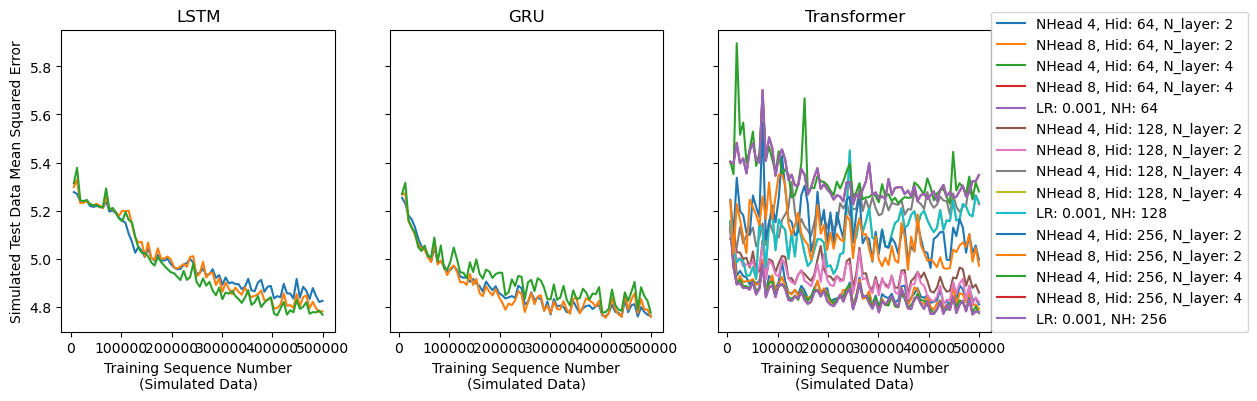

In [48]:
# Build the train on Sim jobs...

n_simulation_sequences_train = 5e5
n_human_sequences_train = 0
human_lr = 0

res_params = {}
res_losses = {}
for m_name in model_names:
    res_params[m_name] = []
    res_losses[m_name] = []


fig,ax = plt.subplots(1,3, figsize = (12,4), dpi = 100, sharex = True, sharey = True)
for model_idx, model_name in enumerate(model_names):
    for sim_lr_idx, sim_lr in enumerate(sim_lrs):
        for d_model in hidden_sizes:
            for dropout in [.2]:
                if model_name == 'Transformer':
                    for n_layers in transformer_layers:
                        for n_head in transformer_attention_heads:
                            mean_loss, sem_loss, train_sequence_number, simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout,n_runs = 3)                
                            ax[model_idx].plot(train_sequence_number, mean_loss, label='NHead {}, Hid: {}, N_layer: {}'.format(n_head, d_model, n_layers))
                            #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                            ax[model_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');
                            ax[model_idx].set_title(model_name)

                            res_losses[model_name].append(mean_loss)
                            res_params[model_name].append(res_name)


                else:
                    n_head = 0
                    n_layers = 0
                    mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train,dropout, n_runs = 3)

                
                ax[model_idx].plot(train_sequence_number, mean_loss, label='LR: {}, NH: {}'.format(sim_lr, d_model))
                #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                ax[model_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');
                ax[model_idx].set_title(model_name)
                
                res_losses[model_name].append(mean_loss)
                res_params[model_name].append(res_name)

                
ax[2].legend(loc=(1, 0))
ax[0].set_ylabel('Simulated Test Data Mean Squared Error');
                
print('Best params train sim test sim \n')

best_params_train_sim_test_sim = {}
for model_name in model_names:
    best_params = get_best_params(res_losses,res_params, model_name, simulation_sequence_number, human_sequence_number)
    print('{} : {} \n'.format(model_name, best_params))
    best_params_train_sim_test_sim[model_name] = get_best_params(res_losses,res_params, model_name, train_sequence_number, human_sequence_number)

    
# save best params in the folder..
best_param_dict['train_sim_test_sim'] = best_params_train_sim_test_sim

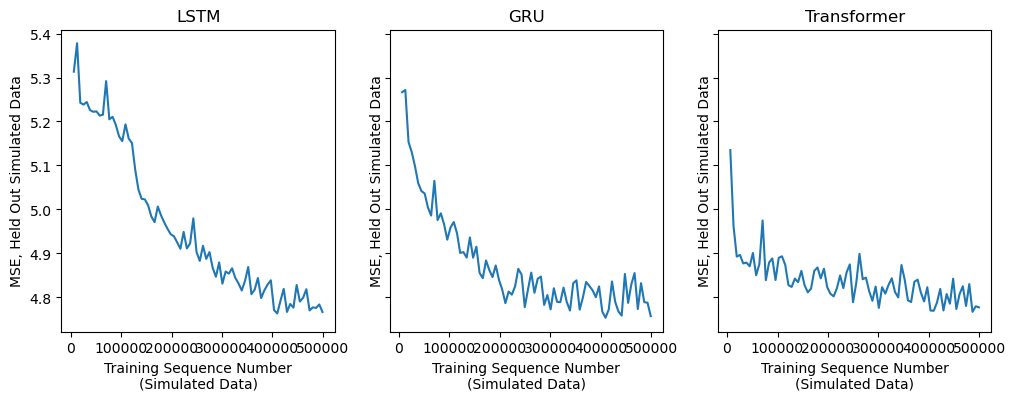

In [49]:
fig,ax = plt.subplots(1,3, figsize = (12,4), dpi = 100, sharex = True, sharey = True)
for model_idx, model_name in enumerate(model_names):
    bp = best_params_train_sim_test_sim[model_name]
    mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, bp['d_model'], bp['sim_lr'], bp['human_lr'], bp['n_head'], bp['n_layers'], bp['n_simulation_sequences_train'], bp['n_human_sequences_train'], bp['dropout'], n_runs = 3, which_loss = 'simulation_loss_results')                
    ax[model_idx].plot(train_sequence_number, mean_loss, label='LR: {}, NH: {}'.format(sim_lr, d_model))
    #ax[model_idx].errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
    ax[model_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');
    ax[model_idx].set_title(model_name)
    ax[model_idx].set_ylabel('MSE, Held Out Simulated Data')
    
    res_losses[model_name].append(mean_loss)
    res_params[model_name].append(res_name)
    

In [50]:
bp

{'model_name': 'Transformer',
 'd_model': 64,
 'sim_lr': 0.001,
 'human_lr': 0,
 'n_head': 8,
 'n_layers': 4,
 'n_simulation_sequences_train': 500000.0,
 'n_human_sequences_train': 0,
 'dropout': 0.2,
 'best_sim_num': 486432,
 'best_hum_num': 0,
 'min_loss': 4.766811415553093}

#### Results for train sim / test human

Best params train sim test human 

LSTM : {'model_name': 'LSTM', 'd_model': 256, 'sim_lr': 0.001, 'human_lr': 0, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0.2, 'best_sim_num': 70432, 'best_hum_num': 0, 'min_loss': 5.78368719915549} 

GRU : {'model_name': 'GRU', 'd_model': 128, 'sim_lr': 0.001, 'human_lr': 0, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0.2, 'best_sim_num': 467232, 'best_hum_num': 0, 'min_loss': 5.845758552352588} 

Transformer : {'model_name': 'Transformer', 'd_model': 256, 'sim_lr': 0.001, 'human_lr': 0, 'n_head': 8, 'n_layers': 4, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0.2, 'best_sim_num': 121632, 'best_hum_num': 0, 'min_loss': 5.759298990170161} 



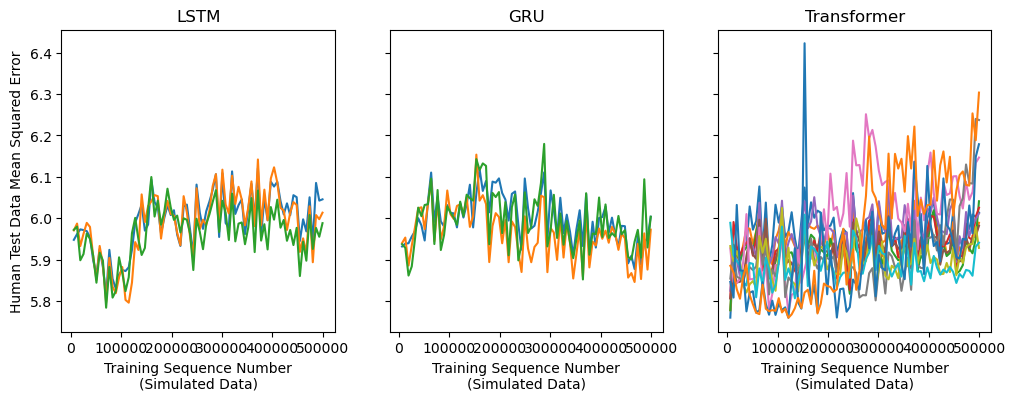

In [51]:
# Build the train on Sim jobs...
n_simulation_sequences_train = 5e5
n_human_sequences_train = 0
human_lr = 0

res_params = {}
res_losses = {}
for m_name in model_names:
    res_params[m_name] = []
    res_losses[m_name] = []


fig,ax = plt.subplots(1,3, figsize = (12,4), dpi = 100, sharex = True, sharey = True)
for model_idx, model_name in enumerate(model_names):
    for sim_lr in sim_lrs:
        for d_model in hidden_sizes:
            for dropout in [.2]:
                if model_name == 'Transformer':
                    for n_layers in transformer_layers:
                        for n_head in transformer_attention_heads:
                            mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 3, which_loss = 'human_loss_results')                
                            ax[model_idx].plot(train_sequence_number, mean_loss, label='LR: {}, NH: {}'.format(sim_lr, d_model))
                            #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                            ax[model_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');
                            ax[model_idx].set_title(model_name)

                            res_losses[model_name].append(mean_loss)
                            res_params[model_name].append(res_name)


                else:
                    n_head = 0
                    n_layers = 0
                    mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 3, which_loss = 'human_loss_results')

                    ax[model_idx].plot(train_sequence_number, mean_loss, label='LR: {}, NH: {}'.format(sim_lr, d_model))
                    #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                    ax[model_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');
                    ax[model_idx].set_title(model_name)

                    res_losses[model_name].append(mean_loss)
                    res_params[model_name].append(res_name)

ax[0].set_ylabel('Human Test Data Mean Squared Error');

print('Best params train sim test human \n')

best_params_train_sim_test_human = {}
for model_name in model_names:
    best_params_train_sim_test_human[model_name] = get_best_params(res_losses,res_params, model_name, simulation_sequence_number, human_sequence_number)
    print('{} : {} \n'.format(model_name, best_params_train_sim_test_human[model_name]))
    
best_param_dict['train_sim_test_human'] = best_params_train_sim_test_human

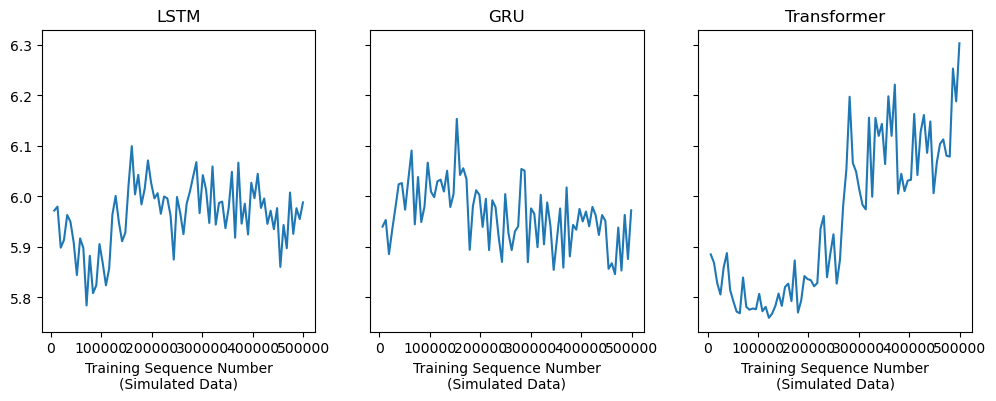

In [52]:
fig,ax = plt.subplots(1,3, figsize = (12,4), dpi = 100, sharex = True, sharey = True)
for model_idx, model_name in enumerate(model_names):
    bp = best_params_train_sim_test_human[model_name]
    mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, bp['d_model'], bp['sim_lr'], bp['human_lr'], bp['n_head'], bp['n_layers'], bp['n_simulation_sequences_train'], bp['n_human_sequences_train'], bp['dropout'], n_runs = 3, which_loss = 'human_loss_results')                
    ax[model_idx].plot(train_sequence_number, mean_loss, label='LR: {}, NH: {}'.format(sim_lr, d_model))
    #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
    ax[model_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');
    ax[model_idx].set_title(model_name)

    res_losses[model_name].append(mean_loss)
    res_params[model_name].append(res_name)

#### Results for train human / test human

Best params train human test human 

LSTM : {'model_name': 'LSTM', 'd_model': 128, 'sim_lr': 0, 'human_lr': 0.0001, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 0, 'n_human_sequences_train': 1000000.0, 'dropout': 0.2, 'best_sim_num': 0, 'best_hum_num': 697600, 'min_loss': 5.687340214848518} 

GRU : {'model_name': 'GRU', 'd_model': 64, 'sim_lr': 0, 'human_lr': 0.0001, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 0, 'n_human_sequences_train': 1000000.0, 'dropout': 0.2, 'best_sim_num': 0, 'best_hum_num': 563200, 'min_loss': 5.688026860356331} 

Transformer : {'model_name': 'Transformer', 'd_model': 64, 'sim_lr': 0, 'human_lr': 0.0001, 'n_head': 4, 'n_layers': 4, 'n_simulation_sequences_train': 0, 'n_human_sequences_train': 1000000.0, 'dropout': 0.2, 'best_sim_num': 0, 'best_hum_num': 102400, 'min_loss': 5.71699417134126} 



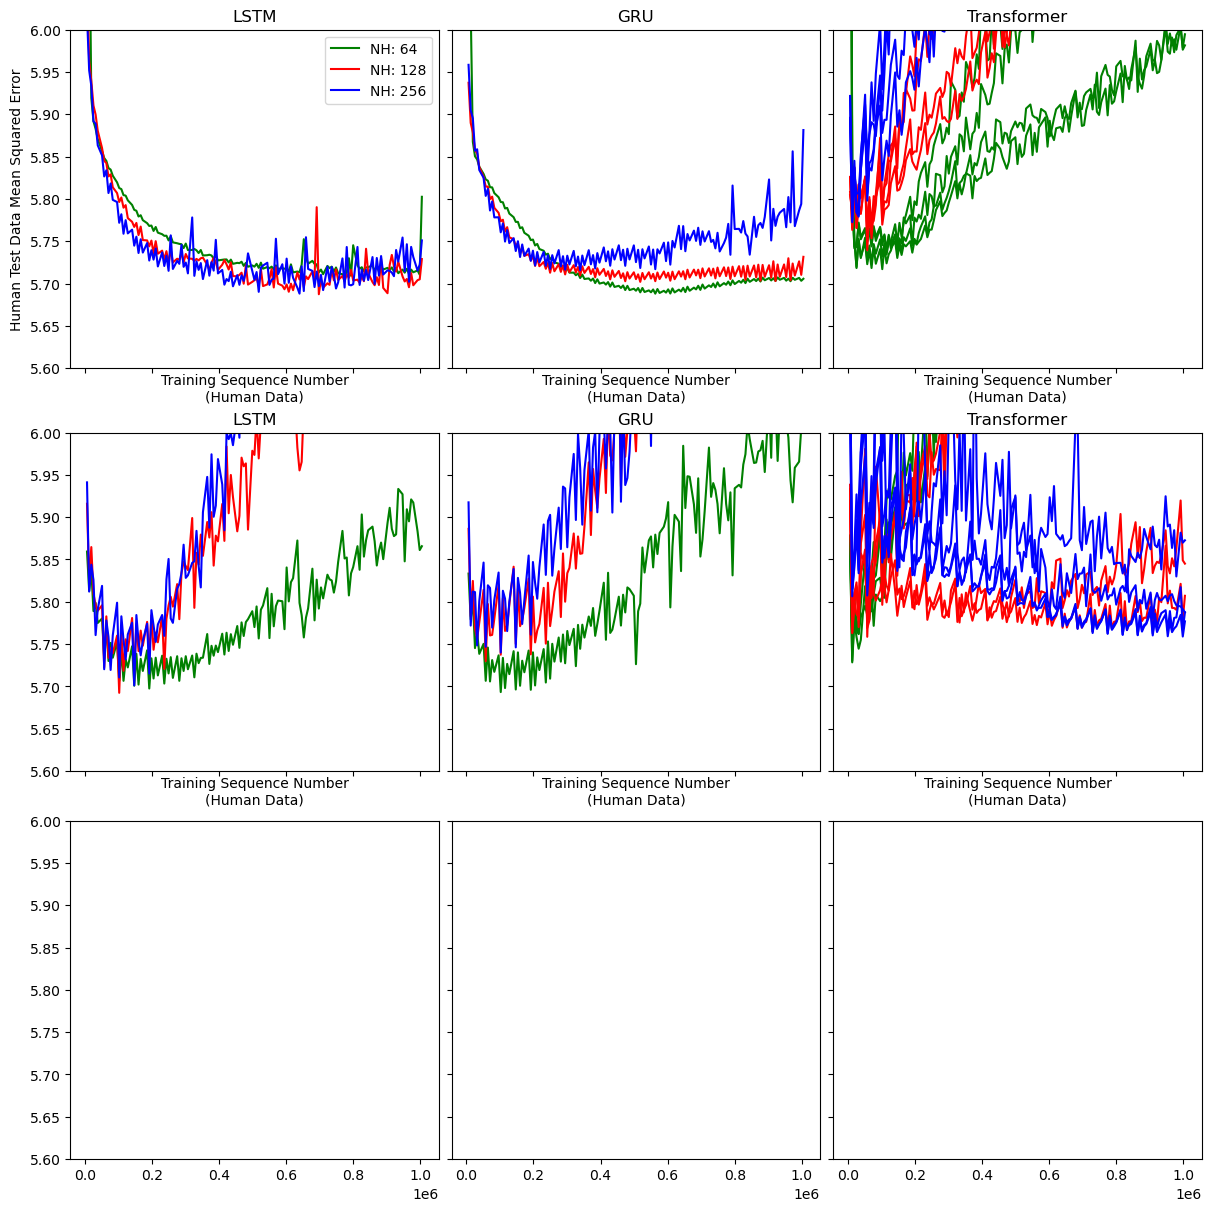

In [53]:
# Add the train on human jobs alone...
n_simulation_sequences_train = 0
n_human_sequences_train = 1e6#7.5e5 
sim_lr = 0
# human_lrs_train = np.array([1e-5,1e-4, 1e-3])
# human_lrs_train = np.array([ 1e-4])
# hidden_sizes = np.array([64, 128, 256, 512])

# min_n_human_seqs_train = 2e6

res_params = {}
res_losses = {}
for m_name in model_names:
    res_params[m_name] = []
    res_losses[m_name] = []

colors = ['green', 'red', 'blue', 'grey']

fig,ax = plt.subplots(3,3, figsize = (12,12), dpi = 100, sharex = True, sharey = True, constrained_layout = True)

for model_idx, model_name in enumerate(model_names):
     for human_lr_idx, human_lr in enumerate(human_lrs_train):
        for d_idx, d_model in enumerate(hidden_sizes):
            for dropout in [.2]:
                
                if model_name == 'Transformer':
                    for n_layers in transformer_layers:
                        for n_head in transformer_attention_heads:
                            mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 3, which_loss = 'human_loss_results')                
                            ax[human_lr_idx,model_idx].plot(train_sequence_number, mean_loss, c=colors[d_idx], label='NH: {}'.format(d_model))
                            #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                            ax[human_lr_idx,model_idx].set_xlabel('Training Sequence Number\n(Human Data)');
                            ax[human_lr_idx,model_idx].set_title(model_name)

                            res_losses[model_name].append(mean_loss)
                            res_params[model_name].append(res_name)


                else:


                    n_head = 0
                    n_layers = 0
                    mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 3, which_loss = 'human_loss_results')
                    # print(mean_loss, end = '\n')
                    ax[human_lr_idx,model_idx].plot(train_sequence_number, mean_loss, c=colors[d_idx], label='NH: {}'.format(d_model))
                    #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                    ax[human_lr_idx,model_idx].set_xlabel('Training Sequence Number\n(Human Data)');
                    ax[human_lr_idx,model_idx].set_title(model_name)
                    mean_loss = np.array(mean_loss)
                    res_losses[model_name].append(mean_loss[-int(min_n_human_seqs_train):])
                    res_params[model_name].append(res_name)

ax[0,0].legend()
                    


ax[0,0].set_ylabel('Human Test Data Mean Squared Error');

ax[0,0].set_ylim(5.6,6.0)

print('Best params train human test human \n')

best_params_train_human_test_human = {}
for model_name in model_names:
    best_params_train_human_test_human[model_name] = get_best_params(res_losses,res_params, model_name, simulation_sequence_number, human_sequence_number)
    print('{} : {} \n'.format(model_name, best_params_train_human_test_human[model_name]))

### notes -- need to run this with more seqs...

best_param_dict['train_human_test_human'] = best_params_train_human_test_human
# re-run w/ 2 mil...

#### Results for train human + sim / test human

Best params train sim and human test human 

LSTM : {'model_name': 'LSTM', 'd_model': 256, 'sim_lr': 0.001, 'human_lr': 0.001, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 300000.0, 'n_human_sequences_train': 1000000.0, 'dropout': 0.2, 'best_sim_num': 294432, 'best_hum_num': 12800, 'min_loss': 5.643615245819092} 

GRU : {'model_name': 'GRU', 'd_model': 128, 'sim_lr': 0.001, 'human_lr': 0.0001, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 300000.0, 'n_human_sequences_train': 1000000.0, 'dropout': 0.2, 'best_sim_num': 294432, 'best_hum_num': 70400, 'min_loss': 5.633929009238879} 

Transformer : {'model_name': 'Transformer', 'd_model': 64, 'sim_lr': 0.001, 'human_lr': 0.0001, 'n_head': 8, 'n_layers': 4, 'n_simulation_sequences_train': 300000.0, 'n_human_sequences_train': 1000000.0, 'dropout': 0.2, 'best_sim_num': 294432, 'best_hum_num': 25600, 'min_loss': 5.623627031842868} 



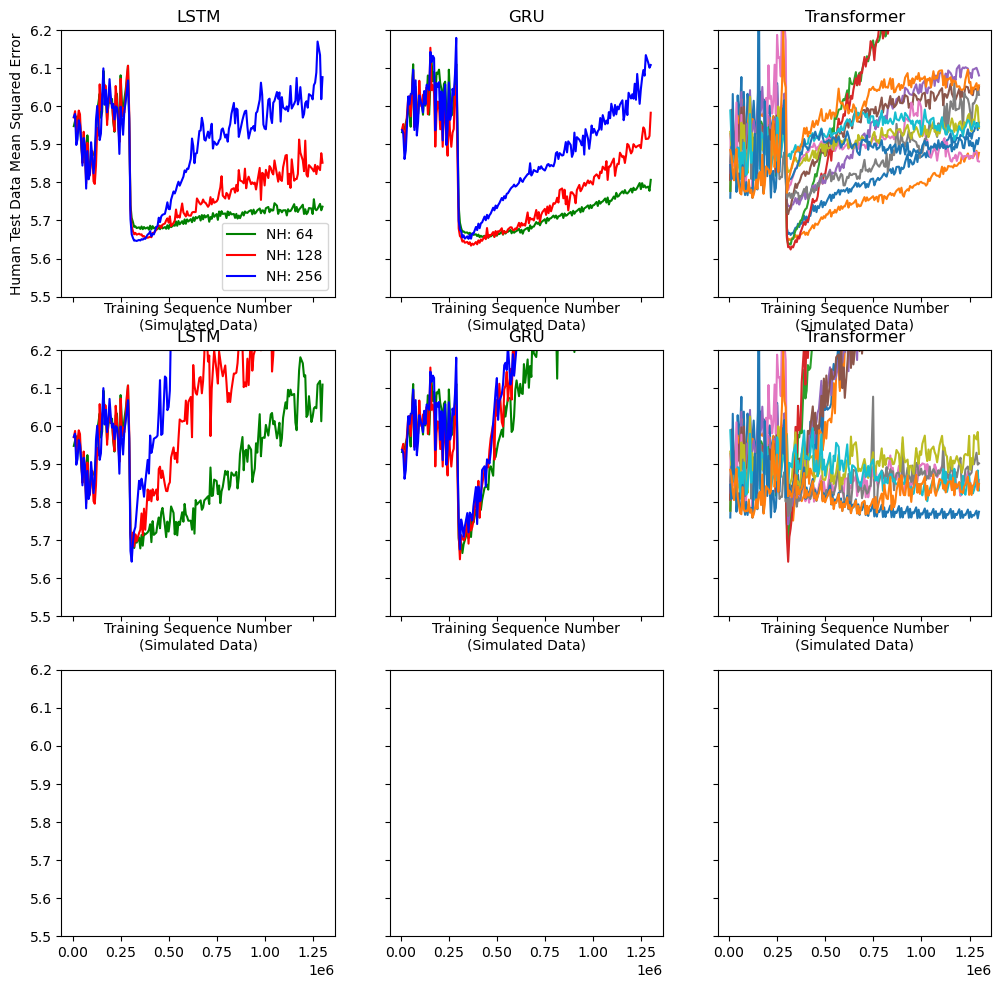

In [54]:
# Add the train on human jobs alone...
n_simulation_sequences_train = 3e5
n_human_sequences_train = 1e6# 2e5 
sim_lr = .001

res_params = {}
res_losses = {}
for m_name in model_names:
    res_params[m_name] = []
    res_losses[m_name] = []


fig,ax = plt.subplots(3,3, figsize = (12,12), dpi = 100, sharex = True, sharey = True)

for model_idx, model_name in enumerate(model_names):
     for human_lr_idx, human_lr in enumerate(human_lrs_finetune):#:enumerate([.0001]):#enumerate(human_lrs_finetune):
        for d_idx, d_model in enumerate(hidden_sizes):
            for dropout in [.2]:

                if model_name == 'Transformer':
                    for n_layers in transformer_layers:
                        for n_head in transformer_attention_heads:
                            mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 3, which_loss = 'human_loss_results')                
                            ax[human_lr_idx,model_idx].plot(train_sequence_number, mean_loss, label='LR: {}, NH: {}'.format(sim_lr, d_model))
                            #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                            ax[human_lr_idx,model_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');
                            ax[human_lr_idx,model_idx].set_title(model_name)

                            res_losses[model_name].append(mean_loss)
                            res_params[model_name].append(res_name)


                else:

                    n_head = 0
                    n_layers = 0
                    mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 3, which_loss = 'human_loss_results')

                    ax[human_lr_idx,model_idx].plot(train_sequence_number, mean_loss, c=colors[d_idx], label='NH: {}'.format(d_model))
                    #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                    ax[human_lr_idx,model_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');
                    ax[human_lr_idx,model_idx].set_title(model_name)

                    res_losses[model_name].append(mean_loss)
                    res_params[model_name].append(res_name)

                
ax[0,0].set_ylabel('Human Test Data Mean Squared Error');
ax[0,0].legend();

ax[0,0].set_ylim(5.5,6.2)

print('Best params train sim and human test human \n')

best_params_train_sim_human_test_human = {}
for model_name in model_names:
    best_params_train_sim_human_test_human[model_name] = get_best_params(res_losses,res_params, model_name, simulation_sequence_number, human_sequence_number)
    print('{} : {} \n'.format(model_name, best_params_train_sim_human_test_human[model_name]))

best_param_dict['train_sim_human_test_human'] = best_params_train_sim_human_test_human

{'model_name': 'LSTM', 'd_model': 256, 'sim_lr': 0.001, 'human_lr': 0.001, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 300000.0, 'n_human_sequences_train': 1000000.0, 'dropout': 0.2, 'best_sim_num': 294432, 'best_hum_num': 12800, 'min_loss': 5.643615245819092}
{'model_name': 'LSTM', 'd_model': 128, 'sim_lr': 0, 'human_lr': 0.0001, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 0, 'n_human_sequences_train': 1000000.0, 'dropout': 0.2, 'best_sim_num': 0, 'best_hum_num': 697600, 'min_loss': 5.687340214848518}
{'model_name': 'GRU', 'd_model': 128, 'sim_lr': 0.001, 'human_lr': 0.0001, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 300000.0, 'n_human_sequences_train': 1000000.0, 'dropout': 0.2, 'best_sim_num': 294432, 'best_hum_num': 70400, 'min_loss': 5.633929009238879}
{'model_name': 'GRU', 'd_model': 64, 'sim_lr': 0, 'human_lr': 0.0001, 'n_head': 0, 'n_layers': 0, 'n_simulation_sequences_train': 0, 'n_human_sequences_train': 1000000.0, 'dropout': 0

Text(0, 0.5, 'Mean Square Error Human Data')

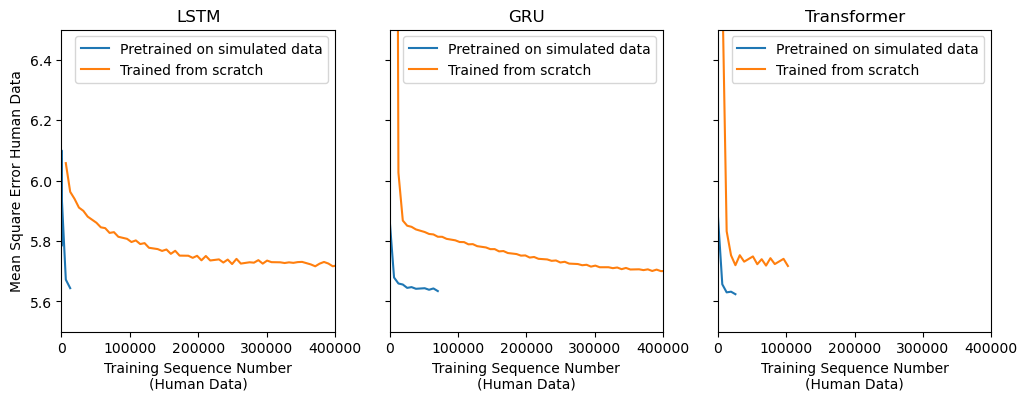

In [56]:
### seems like you're not training on the train data...
fig,ax = plt.subplots(1,3, figsize = (12,4), dpi = 100, sharex = True, sharey = True)
for model_idx, model_name in enumerate(model_names):
    bp = best_params_train_sim_human_test_human[model_name]
    print(bp)
    mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, bp['d_model'], bp['sim_lr'], bp['human_lr'], bp['n_head'], bp['n_layers'], bp['n_simulation_sequences_train'], bp['n_human_sequences_train'], bp['dropout'], n_runs = 3, which_loss = 'human_loss_results')                
    #mean_loss = mean_loss[human_sequence_number != 0]
    #human_sequence_number = human_sequence_number[human_sequence_number != 0]
    
    train_seqs = train_sequence_number[train_sequence_number <= (bp['best_sim_num'] + bp['best_hum_num'])]
    hum_seqs = human_sequence_number[human_sequence_number <= (bp['best_hum_num'])]

    mean_loss = mean_loss[train_sequence_number <= (bp['best_sim_num'] + bp['best_hum_num'])]
    ax[model_idx].plot(hum_seqs, mean_loss, label='Pretrained on simulated data')
    
    bp = best_params_train_human_test_human[model_name]
    print(bp)
    mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(model_name, bp['d_model'], bp['sim_lr'], bp['human_lr'], bp['n_head'], bp['n_layers'], bp['n_simulation_sequences_train'], bp['n_human_sequences_train'], bp['dropout'], n_runs = 3, which_loss = 'human_loss_results')                
    
    train_seqs = train_sequence_number[train_sequence_number <= (bp['best_sim_num'] + bp['best_hum_num'])]
    mean_loss = mean_loss[train_sequence_number <= (bp['best_sim_num'] + bp['best_hum_num'])]

    ax[model_idx].plot(train_seqs, mean_loss, label='Trained from scratch')
    
    #ax.errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
    ax[model_idx].set_xlabel('Training Sequence Number\n(Human Data)');
    ax[model_idx].set_title(model_name)

    res_losses[model_name].append(mean_loss)
    res_params[model_name].append(res_name)
    
    ax[model_idx].legend()
    ax[model_idx].set_xlim(-50,4e5)
    ax[model_idx].set_ylim(5.5,6.5)
    
ax[0].set_ylabel('Mean Square Error Human Data')

In [57]:
### Save the best param dict to a file

f = open(os.path.join(best_param_folder, "best_hyper_params.pkl"),"wb")

# write the python object (dict) to pickle file
pickle.dump(best_param_dict,f)

# close file
f.close()

In [59]:
best_param_dict

{'train_sim_test_sim': {'LSTM': {'model_name': 'LSTM',
   'd_model': 256,
   'sim_lr': 0.001,
   'human_lr': 0,
   'n_head': 0,
   'n_layers': 0,
   'n_simulation_sequences_train': 500000.0,
   'n_human_sequences_train': 0,
   'dropout': 0.2,
   'best_sim_num': 409632,
   'best_hum_num': 0,
   'min_loss': 4.763152907292048},
  'GRU': {'model_name': 'GRU',
   'd_model': 128,
   'sim_lr': 0.001,
   'human_lr': 0,
   'n_head': 0,
   'n_layers': 0,
   'n_simulation_sequences_train': 500000.0,
   'n_human_sequences_train': 0,
   'dropout': 0.2,
   'best_sim_num': 409632,
   'best_hum_num': 0,
   'min_loss': 4.75327084461848},
  'Transformer': {'model_name': 'Transformer',
   'd_model': 64,
   'sim_lr': 0.001,
   'human_lr': 0,
   'n_head': 8,
   'n_layers': 4,
   'n_simulation_sequences_train': 500000.0,
   'n_human_sequences_train': 0,
   'dropout': 0.2,
   'best_sim_num': 486432,
   'best_hum_num': 0,
   'min_loss': 4.766811415553093}},
 'train_sim_test_human': {'LSTM': {'model_name': 'LS